In [1]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [2]:
X = pd.read_csv("data/X_train_NHkHMNU.csv")
y = pd.read_csv("data/y_train_ZAN5mwg.csv")
data = pd.merge(X, y, on="ID")

In [47]:
data

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DELTA_WINDPOW,SUM_WINDPOW,DELTA_RESIDUAL_LOAD,SUM_RESIDUAL_LOAD,DELTA_RAIN,SUM_RAIN,DELTA_WIND,SUM_WIND,DELTA_TEMP,SUM_TEMP
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.303910,-0.842831,1.071327,0.182005,0.383676,-0.729035,-0.507663,-1.073984,-1.005665,-1.132474
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,0.071835,-0.142864,0.787725,-1.578663,-0.469842,-2.010757,0.693919,2.350743,-1.393822,2.268660
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.157515,-0.439994,-0.610648,3.283897,-0.167363,-0.794038,-0.056473,0.918742,0.570048,0.799720
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.376975,0.356795,-0.214915,-2.168863,-0.607268,-1.622408,-0.263161,-0.735658,0.768452,-0.066577
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.210443,-1.339439,1.097880,0.045346,-0.116916,-0.966015,-0.076599,-2.099718,-0.115157,1.343833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,-3.025749,2.911322,1.038269,2.057296,NaN,NaN,NaN,NaN,NaN,NaN
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,-0.590761,0.988474,-0.307326,3.025179,NaN,NaN,NaN,NaN,NaN,NaN
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,-1.285042,-0.678394,1.135751,1.851990,-0.196858,0.612668,-1.488606,0.299415,-0.145978,0.658654
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,1.352048,-0.595889,0.047195,-0.322528,-0.292511,-1.073119,0.529842,-2.474018,-0.123180,2.554235


In [51]:
features = ["CONSUMPTION", "GAS", "COAL", "HYDRO", "NUCLEAR", "SOLAR", "WINDPOW", "RESIDUAL_LOAD", "RAIN", "WIND", "TEMP"]
for feature in features:
    data[f"DELTA_{feature}"] = data[f"DE_{feature}"] - data[f"FR_{feature}"]
    data[f"SUM_{feature}"] = data[f"DE_{feature}"] + data[f"FR_{feature}"]

In [93]:
def preprocess(X, imputer_func, scaler_func=None, poly=None, combine_country_features=False):
    X = pd.get_dummies(X)
    X.loc[:, X.isna().any()] = imputer_func(X.loc[:, X.isna().any()])
    if combine_country_features:
        features = ["CONSUMPTION", "GAS", "COAL", "HYDRO", "NUCLEAR", "SOLAR", "WINDPOW", "RESIDUAL_LOAD", "RAIN", "WIND", "TEMP"]
        for feature in features:
            X[f"DELTA_{feature}"] = X[f"DE_{feature}"] - X[f"FR_{feature}"]
            X[f"SUM_{feature}"] = X[f"DE_{feature}"] + X[f"FR_{feature}"]
    if scaler_func is not None:
        X = scaler_func(X)
    if poly is not None:
        X = poly(X) 
    return X

In [4]:
!pip install tqdm

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [62]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from tqdm import tqdm

def train(model, data, n_splits, imputer=SimpleImputer(), scaler=StandardScaler(), poly=PolynomialFeatures(degree=3)):
    X, y = data.drop(["TARGET", "ID", "DAY_ID"], axis=1), data["TARGET"]
    kf = KFold(n_splits=n_splits)
    results = []
    for train_idx, test_idx in tqdm(kf.split(data)):
        X_train, y_train = X.copy().loc[train_idx], y[train_idx]
        X_test, y_test = X.copy().loc[test_idx], y[test_idx]
        X_train = preprocess(X_train, imputer.fit_transform, scaler.fit_transform, )
        X_test = preprocess(X_test, imputer.transform, scaler.transform, )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rank = evaluate(preds, y_test)
        results.append(rank)
    return results

def evaluate(preds, y_test):
    rank = spearmanr(preds, y_test.values).correlation
    return rank

In [79]:
models = [LinearRegression()]
alphas = np.linspace(1, 1000, 250)
solvers = ["svd", "cholesky", "sparse_cg", "lsqr", "sag", "saga"]
for alpha in alphas:
    for solver in solvers:
        models.append(Ridge(alpha=alpha, solver=solver))
    # models.append(Lasso(alpha=alpha))

In [80]:
results = [train(model, data, 5, poly=None) for model in tqdm(models)]

5it [00:01,  4.67it/s]
5it [00:00, 11.93it/s]
5it [00:00, 13.19it/s]
5it [00:00, 13.05it/s]
5it [00:00, 14.43it/s]
5it [00:02,  2.30it/s]
5it [00:04,  1.18it/s]
5it [00:00, 11.46it/s]
5it [00:00, 12.26it/s]
5it [00:00, 13.96it/s]
5it [00:00,  9.07it/s]
5it [00:01,  4.44it/s]
5it [00:02,  2.30it/s]
5it [00:00,  7.48it/s]
5it [00:00,  9.41it/s]
5it [00:00, 10.81it/s]
5it [00:00, 10.98it/s]
5it [00:02,  1.92it/s]
5it [00:04,  1.20it/s]
5it [00:00,  5.84it/s]
5it [00:00,  9.12it/s]
5it [00:00,  8.04it/s]
5it [00:00,  7.03it/s]
5it [00:01,  4.12it/s]
5it [00:02,  2.33it/s]
5it [00:01,  4.06it/s]
5it [00:00,  5.13it/s]
5it [00:00,  7.44it/s]
5it [00:00,  5.39it/s]
5it [00:00,  6.08it/s]
5it [00:01,  3.32it/s]
5it [00:00, 11.53it/s]
5it [00:00, 11.91it/s]
5it [00:00, 11.98it/s]
5it [00:00, 11.63it/s]
5it [00:00,  5.03it/s]
5it [00:01,  4.87it/s]
5it [00:00,  8.53it/s]
5it [00:00, 10.98it/s]
5it [00:00, 11.82it/s]
5it [00:00, 10.08it/s]
5it [00:00,  6.48it/s]
5it [00:00,  5.13it/s]
5it [00:00,

In [75]:
models[2]

Ridge(alpha=20.0)

In [82]:
def get_model_type(model):
    model_str = model.__str__()
    idx = model_str.index("(")
    return model_str[:idx]

df = pd.DataFrame(
    {
        "model": [get_model_type(model) for model in models], 
        "alpha": [model.__dict__.get("alpha") for model in models], 
        "solver": [model.__dict__.get("solver") for model in models],
        "correlation": [sum(result) / len(result) for result in results],
    }
)
df

,model,alpha,solver,correlation
0,LinearRegression,NaN,None,0.203069
1,Ridge,1.0,svd,0.204489
2,Ridge,1.0,cholesky,0.204489
3,Ridge,1.0,sparse_cg,0.204481
4,Ridge,1.0,lsqr,0.204947
...,...,...,...,...
1496,Ridge,1000.0,cholesky,0.208637
1497,Ridge,1000.0,sparse_cg,0.208645
1498,Ridge,1000.0,lsqr,0.208543
1499,Ridge,1000.0,sag,0.208639


<AxesSubplot: xlabel='alpha', ylabel='correlation'>

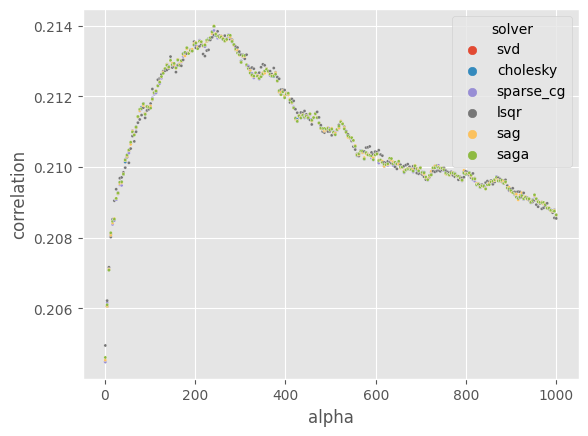

In [87]:
import seaborn as sns

sns.scatterplot(df, x="alpha", y="correlation", hue="solver", s=5)

(0.21, 0.212)

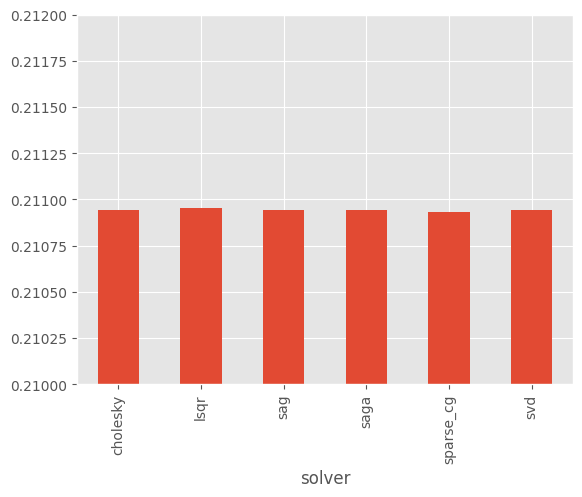

In [92]:
df.groupby("solver")["correlation"].agg("mean").plot(kind="bar")
plt.ylim(0.21, 0.212)

In [83]:
df["correlation"].describe()

count    1501.000000
mean        0.210936
std         0.001632
min         0.203069
25%         0.209728
50%         0.210548
75%         0.212543
max         0.213992
Name: correlation, dtype: float64

In [95]:
best = models[df["correlation"].idxmax()]
best

Ridge(alpha=241.72289156626508, solver='sag')

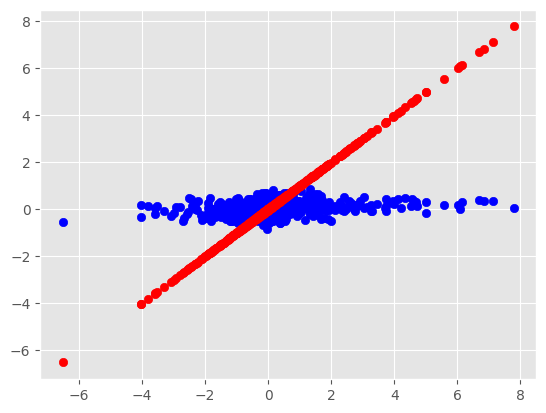

In [98]:
scaler = StandardScaler()
imputer = SimpleImputer()
X_test = preprocess(data.drop(["TARGET", "ID", "DAY_ID"], axis=1), imputer.fit_transform, scaler.fit_transform, combine_country_features=True)
preds = best.predict(X_test)
plt.scatter(data["TARGET"], preds, color="b")
plt.scatter(data["TARGET"], data["TARGET"], color="r")
plt.show()

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00786041, 0.00786041, 0.00786041, 0.06288327,
        0.16506859, 0.19651022, 0.29869554, 0.50

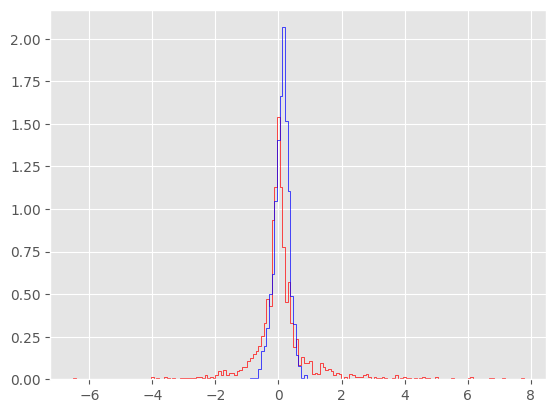

In [104]:
hist, bins, patches = plt.hist(data["TARGET"], color="r", histtype="step", density=True, bins="auto")
plt.hist(preds, color="b", histtype="step", bins=bins, density=True)


In [103]:
len(data["TARGET"])

1494